In [2]:
import numpy as np
import matplotlib.pyplot as plt
from desc.plotting import plot_coils
from desc.coils import (
    CoilSet,
    FourierPlanarCoil,
    SplineXYZCoil,
    MixedCoilSet,
    initialize_modular_coils,
    initialize_saddle_coils,
)

In [3]:
from desc.coils import FourierXYZCoil

In [4]:
FourierXYZCoil()

FourierXYZCoil at 0x116cb2ba0 (name=, current=1.0)

In [6]:
### simple axisymetric coils

In [7]:
###### Background Straight Field
R_coil = 1.3
I = 1e7
N = 2
# pos = np.array([-1,0,1])
pos = np.linspace(0, 2 * np.pi, N)
coils = []

for p in pos:
    c = FourierPlanarCoil(
        current=I,
        center=[10, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils += [c]

In [8]:
## load quad coil 
coilset = CoilSet.from_makegrid_coilfile('../../../../SLAM/Stellarator-Optimization/open-mirror/Paper/minB_coil.coil')

In [9]:
###### Background Straight Field
R_coil = 1.3
I = 1e6
N = 2
# pos = np.array([-1,0,1])

c = FourierXYZCoil(
    current=I,
    X_n=[0, 1, 0, 0],
    Y_n=[0, 0, 1, 0],
    Z_n=[0, 0, 0, 10],
    modes=[0, 1, -1,2],
)
c.change_resolution(N=1000)


In [10]:
coilset = MixedCoilSet(coils)

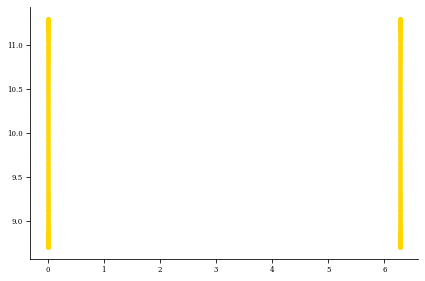

In [11]:
## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    plt.plot(y, x, ".", color="gold")

In [12]:
## field on axis

Text(0, 0.5, '|B|')

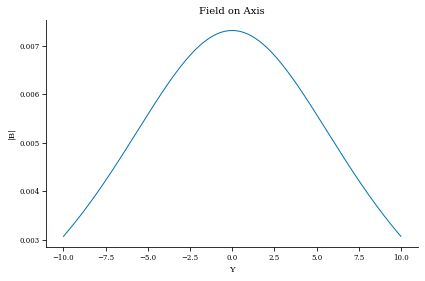

In [13]:
plt.title(r"Field on Axis")
zaxis = np.linspace(-10, 10 , 1000)
yaxis = np.zeros_like(zaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
plt.plot(zaxis, modB)
plt.xlabel("Y")
plt.ylabel("|B|")

Text(0, 0.5, '|B|')

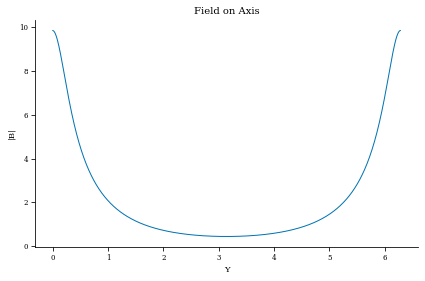

In [14]:
plt.title(r"Field on Axis")
yaxis = np.linspace(0, 2*np.pi , 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) + 10

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
plt.plot(yaxis, modB)
plt.xlabel("Y")
plt.ylabel("|B|")

In [15]:
modB.max()/modB.min()

np.float64(22.536306739736087)

In [18]:
from desc.grid import ConcentricGrid, Grid


def chebygrid(N_grid):
    return np.concatenate(
        (
            [0],
            (-np.cos((2 * np.arange(N_grid) + 1) * np.pi / (2 * N_grid)) + 1) * np.pi,
            [2 * np.pi],
        )
    )


def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid, M=M_grid, N=0, node_pattern=node_pattern).nodes[
        :, :2
    ]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size, 1))
    n = np.tile(Nnodes.reshape(-1, 1), (1, LMnodes.shape[0])).reshape(-1, 1)
    nodes = np.concatenate((lm, n), axis=1)

    # RG: weights and spacing defined here
    # just for the sake of compilation. Must be checked
    weights = np.ones(nodes.shape[0])
    spacing = np.ones_like(nodes)

    spacing[1:, 1] = np.diff(nodes[:, 1])
    spacing[1:, 2] = np.diff(nodes[:, 2])

    return Grid(nodes, spacing=spacing, weights=weights)

In [24]:
# grid = grid_gen(10, 40, 40)

In [25]:
### MGRID
# coilset.save_mgrid('simple_mirror_MR_9',Rmin = 0,Rmax = 1,Zmin = 0, Zmax = 2*np.pi)

In [26]:
#coilset.save_in_makegrid_format("simple_coils_MR_9.coils")

In [27]:
coilset

MixedCoilSet at 0x132aba3c0 (name=, with 2 submembers)

In [195]:
#### SMOLA Coils

In [232]:
def hellical_coil(
    N=100,
    zrange=[0, 1],
    radius=1,
    twists=10,
    handedness="left",
    leads=False,
    lead_offset=10,
):
    N_lead = 1000

    z_start = zrange[0]
    z_end = zrange[1]

    # Parametric coordinate
    theta = np.linspace(0, 2 * np.pi * twists, N * twists)
    y = np.linspace(z_start, z_end, N * twists)

    # Handedness control
    if handedness == "right":
        angle = theta
        switch = -1
    elif handedness == "left":
        angle = theta + np.pi
        switch = 1

    else:
        raise ValueError("handedness must be 'right' or 'left'")

    # Helix coordinates
    x = radius * np.cos(angle)
    z = radius * np.sin(angle)

    xyz = np.transpose([x, y, z])[::-1]

    if leads:
        # Lead 1: straight in -x from y_end
        x_lead1 = np.linspace(x[-1], x[-1] - switch * lead_offset + radius, N_lead)
        y_lead1 = np.full(N_lead, z_end)
        z_lead1 = np.full(N_lead, z[-1])
        xyz_lead1 = np.stack([x_lead1, y_lead1, z_lead1], axis=-1)

        # Lead 2: straight in -x from y_start
        x_lead2 = np.linspace(x[0], x[0] - switch * lead_offset + radius, N_lead)
        y_lead2 = np.full(N_lead, z_start)
        z_lead2 = np.full(N_lead, z[0])
        xyz_lead2 = np.stack([x_lead2, y_lead2, z_lead2], axis=-1)

        # Lead 3: connecting lead1 and lead2

        if switch == 1:
            theta = np.linspace(np.pi / 2, 3 * np.pi / 2, N_lead)
        if switch == -1:
            theta = np.linspace(-np.pi / 2, np.pi / 2, N_lead)

        r_semi = (np.abs(z_end) + np.abs(z_start)) / 2
        x_lead3 = r_semi * np.cos(theta) * 5 - switch * lead_offset
        y_lead3 = r_semi * np.sin(theta)
        z_lead3 = np.full(N_lead, 0)
        xyz_lead3 = np.stack([x_lead3, y_lead3, z_lead3], axis=-1)

        return np.concatenate([xyz, xyz_lead1, xyz_lead3, xyz_lead2[::-1]], axis=0)

    else:

        return xyz

In [388]:
hr = 0.172 / 2
pr = 0.375 / 2
Ih = 26 * 500  # A
Ib = 90 * 500  # A
start = 1.68 + 0.18

gc_shift = 1

## test
method = "linear"
X, Y, Z = hellical_coil(
    N=1000, zrange=[start, start + 2.16], radius=hr, twists=12, handedness="left"
).T
coil1 = SplineXYZCoil(Ih * gc_shift, X, Y, Z, method=method)

X, Y, Z = hellical_coil(
    N=1000, zrange=[start, start + 2.16], radius=hr, twists=12, handedness="right"
).T
coil2 = SplineXYZCoil(-Ih * gc_shift, X, Y, Z, method=method)

from desc.coils import CoilSet
coilset = CoilSet([coil1, coil2])

Text(0, 0.5, '|B|')

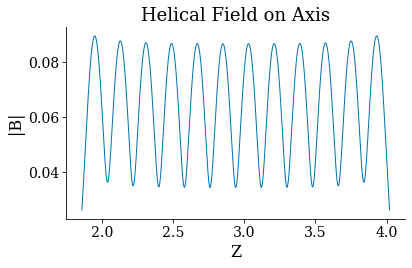

In [390]:
plt.title(r"Helical Field on Axis")
yaxis = np.linspace(start, start + 2.16, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
plt.plot(yaxis, modB)
plt.xlabel("Z")
plt.ylabel("|B|")

In [391]:
###### Background Straight Field
R_coil = pr
# pos = np.array([-1,0,1])
pos = np.linspace(start, start + 2.16, 12)
coils = []

for p in pos:
    c = FourierPlanarCoil(
        current=Ib * gc_shift,
        center=[0, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils += [c]

In [393]:
###### correction  field
R_coil = .1
scale_current = .1
#make a cage, a cube of length 2*rcoil 
centered = start - R_coil*2

left = [0,centered, 0]
right = [0,centered - R_coil, 0 ]

up =    [0,centered, R_coil]
down =  [0,centered, -R_coil]
front = [R_coil,centered,0]
back =  [ -R_coil,centered,0]

pos = np.array([left,righ,front,back,up,down])

coils_c = []

#1
c = FourierPlanarCoil(
    current= Ib * scale_current,
    center= pos[0],
    normal=[0, 1, 0],
    r_n=R_coil,
    modes=[0],
)
c.change_resolution(N=100)
coils_c += [c]


#3
c = FourierPlanarCoil(
    current= Ib * scale_current,
    center= pos[2],
    normal=[1, 0, 0],
    r_n=R_coil,
    modes=[0],
)
c.change_resolution(N=100)
coils_c += [c]

#4
c = FourierPlanarCoil(
    current= Ib * scale_current,
    center= pos[3],
    normal=[1, 0, 0],
    r_n=R_coil,
    modes=[0],
)
c.change_resolution(N=100)
coils_c += [c]

#5
c = FourierPlanarCoil(
    current= Ib * scale_current,
    center= pos[4],
    normal=[0, 0, 1],
    r_n=R_coil,
    modes=[0],
)
c.change_resolution(N=100)
coils_c += [c]

#6
c = FourierPlanarCoil(
    current= Ib * scale_current,
    center= pos[5],
    normal=[0, 0, 1],
    r_n=R_coil,
    modes=[0],
)
c.change_resolution(N=100)
coils_c += [c]

In [398]:
coils += [coils_c,coil1, coil2]
from desc.coils import MixedCoilSet
coilset = MixedCoilSet(coils)

coilset = MixedCoilSet(coils)

/Users/djinpatch/CODE/DESC/desc/utils.py:572: UserWarning: Found coils which are nearly intersecting according to the given grid it is recommended to check coils closely or run function again with a higher resolution grid. Offending coil indices are {16, 13, 14, 15}.
  warnings.warn(msg, err)
/Users/djinpatch/CODE/DESC/desc/utils.py:572: UserWarning: Found coils which are nearly intersecting according to the given grid it is recommended to check coils closely or run function again with a higher resolution grid. Offending coil indices are {16, 13, 14, 15}.
  warnings.warn(msg, err)


In [399]:
coilset_temp = MixedCoilSet(coils[:-2])

/Users/djinpatch/CODE/DESC/desc/utils.py:572: UserWarning: Found coils which are nearly intersecting according to the given grid it is recommended to check coils closely or run function again with a higher resolution grid. Offending coil indices are {16, 13, 14, 15}.
  warnings.warn(msg, err)


Text(0, 0.5, '|B|')

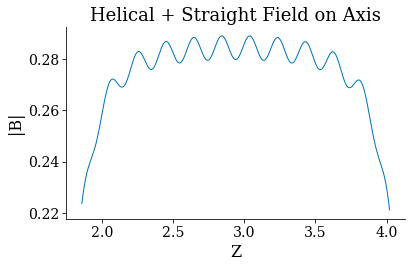

In [400]:
plt.title(r"Helical + Straight Field on Axis")
yaxis = np.linspace(start, start + 2.16, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
B = coilset_temp.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")

modB = np.linalg.norm(B, axis=-1)
plt.plot(yaxis, modB)
plt.xlabel("Z")
plt.ylabel("|B|")

In [401]:
from mayavi import mlab

In [403]:
fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))


mlab.show()

In [409]:
#coilset_temp.coils

In [410]:
### Plasma formation coils
pos_g = np.linspace(0.2, 0.4, 2)
## 7cm VV
Ig = 90 * 1.8 * 500 * gc_shift  # Ampes
R_coil_g = 0.10

### "Smoothing" coils -- lifts B - well
pos_s = np.array([0.6, 0.8, 1.26, 1.46])
Is = 90 * 250 * gc_shift  # Ampes
R_coil_s = 0.375 * 1.5

In [414]:
coils_gun = []

for p in pos_g:
    c = FourierPlanarCoil(
        current=Ig,
        center=[0, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil_g,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils_gun += [c]

coils_large = []

for p in pos_s:
    c = FourierPlanarCoil(
        current=Is,
        center=[0, p, 0],
        normal=[0, 1, 0],
        r_n=R_coil_s,
        modes=[0],
    )
    c.change_resolution(N=100)
    coils_large += [c]

In [416]:
coils_large += [coils_gun]
coils_large += [coils]
coilset = MixedCoilSet(coils_large)

/Users/djinpatch/CODE/DESC/desc/utils.py:572: UserWarning: Found coils which are nearly intersecting according to the given grid it is recommended to check coils closely or run function again with a higher resolution grid. Offending coil indices are {19, 20, 21, 22}.
  warnings.warn(msg, err)


In [417]:
plt.rcParams.update(
    {
        "font.size": 16,  # Default text size
        "axes.titlesize": 18,  # Title font
        "axes.labelsize": 16,  # x/y label font
        "xtick.labelsize": 14,  # Tick font
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    }
)


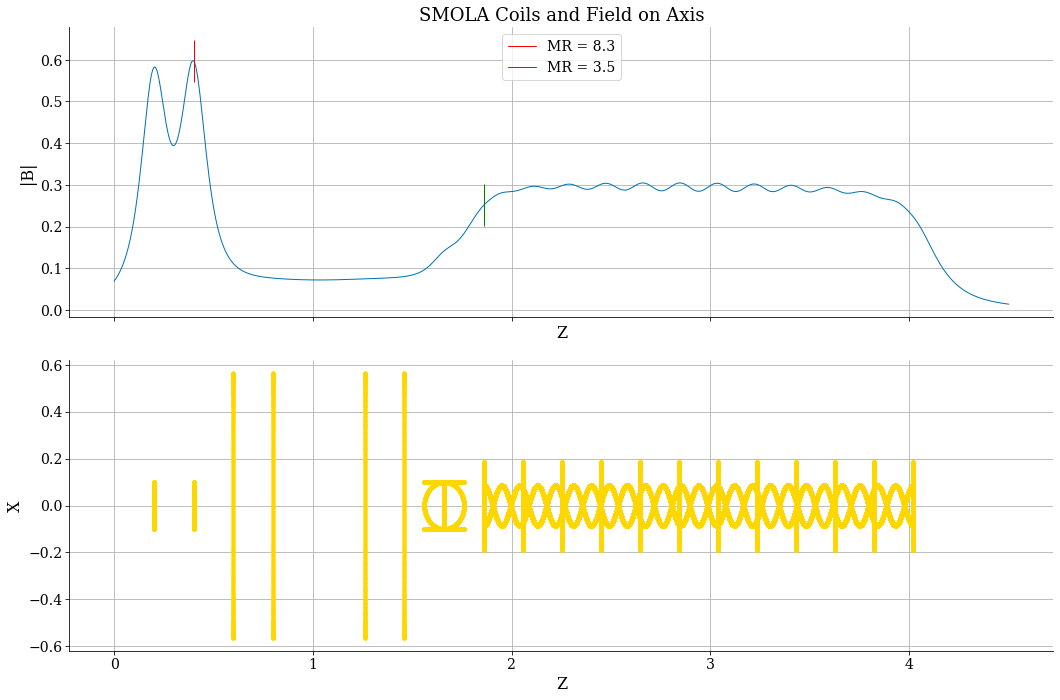

In [420]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[0].set_title(r"SMOLA Coils and Field on Axis")

yaxis = np.linspace(0, 4.5, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0

B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
modB = np.linalg.norm(B, axis=-1)
axs[0].plot(yaxis, modB)


### MR
# B at end of gun
B = coilset.compute_magnetic_field(np.array([0, 0.4, 0]).T, basis="xyz")
Bg = np.linalg.norm(B, axis=-1)

# min in central chamber
yaxis = np.linspace(0.05, 2, 1000)
zaxis = np.zeros_like(yaxis)
xaxis = np.ones_like(zaxis) * 0
B = coilset.compute_magnetic_field(np.array([xaxis, yaxis, zaxis]).T, basis="xyz")
Bmod = np.linalg.norm(B, axis=-1)
Bmin = np.min(Bmod)

# max B at the start of the transport region
B = coilset.compute_magnetic_field(np.array([0, start, 0]).T, basis="xyz")
Bt = np.linalg.norm(B, axis=-1)

gun_mr = Bg / Bmin
transport_mr = Bt / Bmin


axs[0].set_ylabel("|B|")
axs[0].set_xlabel("Z")
axs[0].grid()
axs[0].set_ylabel("|B|")
axs[0].vlines(
    0.4, Bg - 0.05, Bg + 0.05, color="red", label="MR = {:.1f}".format((gun_mr[0]))
)

axs[0].vlines(
    start,
    Bt - 0.05,
    Bt + 0.05,
    color="green",
    label="MR = {:.1f}".format((transport_mr[0])),
)
axs[0].legend(loc="upper center")


coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    axs[1].plot(y, x, ".", color="gold")
axs[1].set_xlabel("Z")
axs[1].set_ylabel("X")
axs[1].grid()

In [421]:
#coilset.save_in_makegrid_format("smola_coils_unscaled.coils")

In [422]:
#coilset.coils

In [423]:
# field lines?de

In [425]:
## CHATGPT

In [426]:
import jax.numpy as jnp
from diffrax import ODETerm, SaveAt, PIDController, Event, diffeqsolve, Tsit5

def field_line_trace_xyz(
    x0, y0, z0,
    *,
    field,                         # object with .compute_magnetic_field(pts, ..., basis="xyz") -> (N,3) (Bx,By,Bz)
    params=None,
    source_grid=None,
    s_total=1.0,                   # arc-length magnitude (meters); direction set by `direction`
    direction="forward",           # "forward" | "backward" | "both"
    rtol=1e-8, atol=1e-8,
    min_step_size=1e-8,            # positive; function assigns the proper sign to dt0
    max_steps_per_meter=20000,     # cap to avoid runaway solves
    bounds_X=(-jnp.inf, jnp.inf),  # terminate the whole batch if any seed exits these bounds
    bounds_Y=(-jnp.inf, jnp.inf),
    bounds_Z=(-jnp.inf, jnp.inf),
    chunk_size=None,
    eps_B=0.0,                     # if >0, treat |B|<eps_B as eps_B (robust near nulls)
    solver=Tsit5(),
):
    """
    Trace magnetic field lines in Cartesian coordinates using arc length s:

        dX/ds = Bx/|B|,  dY/ds = By/|B|,  dZ/ds = Bz/|B|.

    SEEDS
    -----
    x0, y0, z0 : scalars or arrays with the SAME shape S (e.g. (), (N,), (M,N), ...).
    The solver flattens S to a batch of size N and reshapes back on output.

    RETURNS
    -------
    ts, path
      ts   : (nsteps,)     arc-length samples (for "both", ts<0 is the back half, ts>=0 forward)
      path : (nsteps, *S, 3) with last axis = (X,Y,Z)

    NOTES
    -----
    - Use direction="backward" to go opposite B, or "both" to get a continuous trajectory
      through the start (backward reversed, then forward; no duplicate at s=0).
    - If your start is exactly at a true B=0 null, offset the seed by a tiny radius.
    """
    # ----- batch seeds (component-first state: (3, N)) -----
    x0 = jnp.asarray(x0); y0 = jnp.asarray(y0); z0 = jnp.asarray(z0)
    assert x0.shape == y0.shape == z0.shape, "x0, y0, z0 must share the same shape"
    S = x0.shape
    N = x0.size
    y_init = jnp.stack([x0.ravel(), y0.ravel(), z0.ravel()], axis=0)   # (3, N)

    # ----- RHS: expects/returns (3, N) -----
    def odefun(s, state, args):
        X, Y, Z = state[0], state[1], state[2]                        # each (N,)
        pts = jnp.stack([X, Y, Z], axis=-1)                           # (N,3)
        B = field.compute_magnetic_field(
            pts, params, basis="xyz", source_grid=source_grid, chunk_size=chunk_size
        )                                                             # (N,3)
        Bn = jnp.linalg.norm(B, axis=-1)
        if eps_B > 0.0:
            Bn = jnp.maximum(Bn, eps_B)
        else:
            Bn = jnp.where(Bn == 0.0, 1.0, Bn)                        # avoid /0 at exact nulls
        dX, dY, dZ = (B[:, 0]/Bn, B[:, 1]/Bn, B[:, 2]/Bn)             # each (N,)
        return jnp.stack([dX, dY, dZ], axis=0)                        # (3, N)

    term = ODETerm(odefun)
    stepsize = PIDController(rtol=rtol, atol=atol, dtmin=jnp.abs(min_step_size))
    save_steps = SaveAt(steps=True)

    # ----- termination: stop whole batch if ANY seed exits bounds -----
    def cond_fn(t, y, args, **_ignored):
        X, Y, Z = y[0], y[1], y[2]                                    # each (N,)
        out = (
            (X < bounds_X[0]) | (X > bounds_X[1]) |
            (Y < bounds_Y[0]) | (Y > bounds_Y[1]) |
            (Z < bounds_Z[0]) | (Z > bounds_Z[1])
        )
        return jnp.any(out)  # boolean: terminate when True

    ev = Event(cond_fn=cond_fn)

    def _solve(sign):
        # sign: +1 forward, -1 backward
        s_mag = float(abs(s_total))
        t0, t1 = 0.0, float(sign) * s_mag
        dt0 = float(sign) * float(jnp.abs(min_step_size))             # sign must match t1 - t0
        max_steps = int(max(1.0, s_mag) * max_steps_per_meter)

        sol = diffeqsolve(
            term, solver,
            t0=t0, t1=t1, y0=y_init,
            dt0=dt0,
            stepsize_controller=stepsize,
            saveat=save_steps,
            max_steps=max_steps,
            event=ev,                                                 # new API
        )
        ts, ys = sol.ts, sol.ys                                       # ys: (nsteps, 3, N)
        path = jnp.moveaxis(ys, 1, -1).reshape(len(ts), *S, 3)        # -> (nsteps, *S, 3)
        return ts, path

    dir_lc = direction.lower()
    if dir_lc not in ("forward", "backward", "both"):
        raise ValueError("direction must be 'forward', 'backward', or 'both'")

    if dir_lc == "forward":
        return _solve(+1)
    if dir_lc == "backward":
        return _solve(-1)

    # "both": backward then forward; concatenate with clean s-axis
    ts_b, pb = _solve(-1)
    ts_f, pf = _solve(+1)
    # reverse the backward half, drop duplicate start, make its s negative
    ts = jnp.concatenate([-ts_b[::-1][:-1], ts_f])                    # (nb-1 + nf,)
    path = jnp.concatenate([pb[::-1][:-1], pf], axis=0)               # (same, *S, 3)
    return ts, path

In [268]:
N = 10
r = .1
theta = np.linspace(0,2*np.pi,N,endpoint = False) 
rs = np.ones_like(theta)*r
x0 = r * np.cos(theta) 
z0 = r * np.sin(theta)
y0 = np.ones_like(z0)* 1

In [269]:
N = 30
r = .05
theta = np.linspace(0,2*np.pi,N,endpoint = False) 
rs = np.ones_like(theta)*r
x0 = r * np.cos(theta) 
z0 = r * np.sin(theta)
y0 = np.ones_like(z0)* 1

In [270]:
N = 20
r = .1
theta = np.linspace(0,np.pi/2,N,endpoint = True) 
rs = np.ones_like(theta)*r
x0 = r * np.cos(theta) 
y0 = r * np.sin(theta)
z0 = np.ones_like(y0)* 0

In [433]:
N = 10
r = .01
theta = np.linspace(0,2*np.pi,N,endpoint = False) 
rs = np.ones_like(theta)*r
x0 = r * np.cos(theta) 
z0 = r * np.sin(theta)
y0 = np.ones_like(z0) * 3

In [435]:
ts, path = field_line_trace_xyz(
    x0, y0, z0,
    field=coilset,          # must return (Bx,By,Bz) in basis="xyz"
    s_total= 2, #.2,            # arc-length to trace (meters)
    direction="both",       # "forward", "backward", or "both"
    bounds_X=(-1e9, 1e9),   # widen if you don’t want early termination
    bounds_Y=(-1e9, 1e9),
    bounds_Z=(-1e9, 1e9),
)
# path shape: (nsteps, N, 3); coordinates are path[:, i, 0]=X, path[:, i, 1]=Y, path[:, i, 2]=Z

In [436]:
#coilset.coils

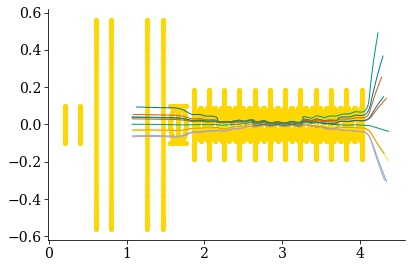

In [437]:
plt.figure()

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    plt.plot(y, x, ".", color="gold")

for i in range(N):
    plt.plot(path[:,i,1],path[:,i,0])

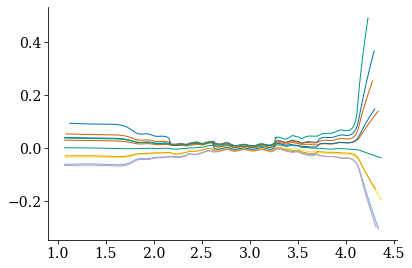

In [438]:

# construct finite valued path 
points = []
B = []
for i in range(N):
    plt.plot(path[:,i,1],path[:,i,0])

    x = path[:,i,0][np.isfinite(path[:,i,0])]
    y = path[:,i,1][np.isfinite(path[:,i,1])]
    z = path[:,i,2][np.isfinite(path[:,i,2])]

    points += [np.array([x,y,z]).T]
    B += [coilset.compute_magnetic_field(np.array([x, y, z]).T, basis="xyz")]

B = np.array(B)
points = np.array(points)

In [386]:
fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

#mlab.quiver3d(points[:,:,0],points[:,:,1],points[:,:,2],B[:,:,0],B[:,:,1],B[:,:,2])

mlab.points3d(points[:,:,0].ravel(),points[:,:,1].ravel(),points[:,:,2].ravel(), np.ravel(np.linalg.norm(B,axis = -1)), scale_factor = .01,opacity=.5)

mlab.show()

In [180]:
def order_z(field_lines,z_stop = False):
    '''
    This function interpolates each fieldline, and evaluates at specific z values to counteract
    shifting in z from the ivp solver. This makes an ordered grid in z that describes the flux surface 
    
    '''
  
    # certain fieldline solvers seem to cause an error with splrep -- ValueError: Error on input data
    # it is beacause z is not strictly increasing and somewhere a fieldline doubled back! 
    # to solve this I np.sort(z) which could be a source of distortion for some fieldline outputs 
    
    field_lines = np.array(field_lines)
    
    
    # find minimal extent in z (+ and -) so we do not extrapolate outside of known values 
    maxlist = []
    for i in range(len(field_lines)):
        maxlist += [np.max(field_lines[i,:,2])]
        
    minlist = []
    for i in range(len(field_lines)):
        minlist += [np.min(field_lines[i,:,2])]
    
    # evaluating each fieldline at the same z range set by max and min z values, or by hand
    
    if z_stop is not False:
        
        specific_z_values = np.linspace(-z_stop,z_stop,len(field_lines[0]))

    else:
        specific_z_values = np.linspace(np.max(np.array(minlist)),np.min(np.array(maxlist)),len(field_lines[0]))
    

    field_lines_x = []
    field_lines_y = []
    field_lines_z = []

    # loop through fieldlines, interpolate, and find solution at specific z values 
            
    for i in range(len(field_lines)):
        x,y,z = field_lines[i,:,:].T
        
        # Create B-spline representations
        tck_x = splrep(np.sort(z), x, k=3)  # cubic B-spline
        tck_y = splrep(np.sort(z), y, k=3)

        interpolated_x = splev(specific_z_values, tck_x)
        interpolated_y = splev(specific_z_values, tck_y)

        # add to new fieldline array 
        field_lines_x += [interpolated_x]
        field_lines_y += [interpolated_y]
        field_lines_z += [specific_z_values] 

    field_lines_x = np.array(field_lines_x)
    field_lines_y = np.array(field_lines_y)
    field_lines_z = np.array(field_lines_z)

    field_lines = np.array([field_lines_x.T,field_lines_y.T,field_lines_z.T]).T 

    
    return field_lines


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x112ea76a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

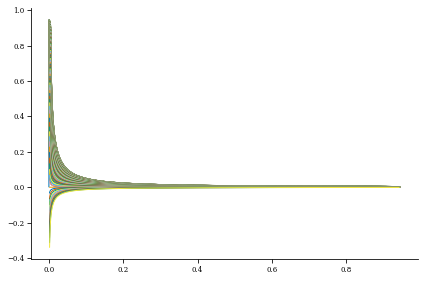

In [38]:
plt.figure()

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    #plt.plot(y, x, ".", color="gold")

# construct finite valued path 
points = []
B = []
for i in range(N):
    plt.plot(path[:,i,1],path[:,i,0])

    x = path[:,i,0][np.isfinite(path[:,i,0])]
    y = path[:,i,1][np.isfinite(path[:,i,1])]
    z = path[:,i,2][np.isfinite(path[:,i,2])]

    points += [np.array([x,y,z]).T]
    B += [coilset.compute_magnetic_field(np.array([x, y, z]).T, basis="xyz")]

B = np.array(B)
points = np.array(points)

In [ ]:
Bmag = np.linalg.norm(B,axis = -1)

In [ ]:
for i in range(N):
    plt.scatter(points[i,:,2],points[i,:,0],c = Bmag[i])

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#from scipy.interpolate import RegularGridInterpolator as RgInt
from scipy.interpolate import splrep,splprep, splev, interpn


In [53]:
points = order_z(points)

In [633]:
points.shape

(21, 50, 3)

In [ ]:
fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

#for i in range(N):
    #mlab.points3d(path[:,i,0],path[:,i,1],path[:,i,2],scale_factor = .01,opacity=1, color = (1,.5,.5))
    
mlab.show()

In [1005]:
from mayavi import mlab

In [331]:
## plot B vectors 
# cylindrical grid
points = []
B = []
Ny = 10
Nt = 10
radial = np.linspace(.01,.01,1)
for r in radial:
    y = np.linspace(2,4,Ny)
    for yi in y:
        theta = np.linspace(0,2*np.pi,Nt)
        x = r*np.cos(theta)
        z = r*np.sin(theta)
        yt = np.ones_like(x)*yi
        points += [np.array([x,yt,z]).T]
        B += [coilset.compute_magnetic_field(np.array([x, yt, z]).T, basis="xyz")]


points = np.array(points)
B = np.array(B)


In [333]:
points.shape

(10, 10, 3)

In [335]:
fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

mlab.quiver3d(points[:,:,0],points[:,:,1],points[:,:,2],B[:,:,0],B[:,:,1],B[:,:,2])

#mlab.points3d(points[:,:,0].ravel(),points[:,:,1].ravel(),points[:,:,2].ravel(),scale_factor = .01,opacity=.5, color = (.5,.5,.5))

mlab.show()

In [637]:
### remove all inf 
path_t = path[np.isfinite(path)]

In [639]:
path_t.shape

(3150,)

In [641]:
path_t.shape

(3150,)

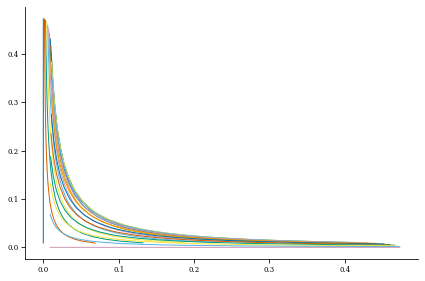

In [182]:
plt.figure()

## plot coils

coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
    #plt.plot(y, x, ".", color="gold")

# construct finite valued path 
points = []
for i in range(N):
    plt.plot(path[:,i,1],path[:,i,0])

    x = path[:,i,0][np.isfinite(path[:,i,0])]
    y = path[:,i,1][np.isfinite(path[:,i,1])]
    z = path[:,i,2][np.isfinite(path[:,i,2])]

    points += [np.array([x,y,z]).T]
    
points = np.array(points)

In [184]:
points = order_z(points)

In [188]:
from desc.geometry.surface import ChebyshevRZToroidalSurface
from desc.plotting import *
from desc.grid import Grid

In [190]:
points.shape

(20, 33, 3)

In [192]:
X = points[:,:,0].ravel()
Y = points[:,:,1].ravel()
Z = points[:,:,2].ravel()


In [194]:
fig = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0.0, 0.0, 0.0))



coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

#mlab.quiver3d(points[:,:,0],points[:,:,1],points[:,:,2],B[:,:,0],B[:,:,1],B[:,:,2])



mlab.points3d(X,Y,Z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))



mlab.show()

In [108]:
## modification for quad coil
X = points[:,:,0].ravel() + 100 
Z = points[:,:,1].ravel()
Y = points[:,:,2].ravel()

In [110]:
xf = points[:,:,0].ravel()
yf = points[:,:,1].ravel()
zf = points[:,:,2].ravel()

### transform z to zeta
z_min = np.min(zf)
z_max = np.max(zf)

### old length
L_old = np.abs(z_min) + z_max
L_new = 2 * np.pi
scale = 1 #L_new / L_old

# Shift and scale to get zeta in [0, 2π]
Y = 2 * np.pi * (zf - z_min) / (z_max - z_min)
X = xf * scale + 10
Z = yf * scale

In [112]:
Radius = np.sqrt(Z**2 + X**2)
#Rho = np.ones_like(X)
Theta = np.arctan2(Z,X-10)
Zeta = Y

In [114]:
target_values = np.array([Radius,Zeta,Z]).T

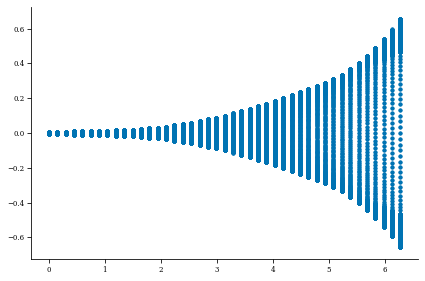

In [116]:
plt.plot(Y,Z,'.')

In [129]:
surf = ChebyshevRZToroidalSurface.from_values(target_values,Theta,Zeta, N = 5, M = 15)

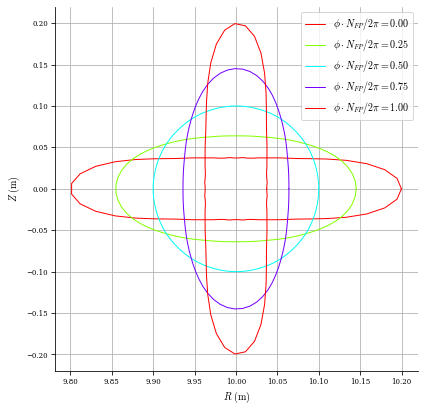

In [130]:
data = plot_boundary(surf,plot_axis=False,phi = np.linspace(0,2*np.pi,5),return_data = True)
plt.grid()

In [95]:
Nz = 200
Nt = 50
rho_surf = .5

# Flux surfaces on which to evaluate 
surfaces = np.array([rho_surf])
# Field lines on which to evaluate 
alpha = np.linspace(0, 2 * np.pi, Nt, endpoint=False)
# Number of point along a field line 
zeta = np.linspace(0, 2 * np.pi, Nz)

# we need to make a special grid in field aligned coordinates, which we do here
# coordinates="raz" tells desc that this grid is in rho,alpha,zeta coordinates.
grid = Grid.create_meshgrid([surfaces, alpha, zeta], coordinates="raz")

In [97]:
data = surf.compute(
    [
        "X",
        "Y",
        "Z", 
    ],
    grid=grid,
)

/Users/djinpatch/CODE/DESC/desc/utils.py:572: UserWarning: Expected coordinates rtz got raz.
  warnings.warn(msg, err)


In [99]:
x = data['X'].reshape(Nz,Nt).T
y = data['Y'].reshape(Nz,Nt).T
z = data['Z'].reshape(Nz,Nt).T

/var/folders/t3/4w9l289j4ssdzgq5bgcflr9r0000gn/T/ipykernel_21782/2607856918.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  base = plt.scatter(y[:,:],z[:,:],alpha = 1, cmap = 'RdBu')


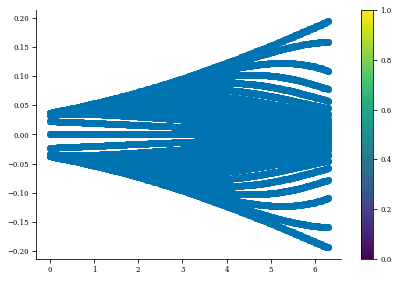

In [101]:
base = plt.scatter(y[:,:],z[:,:],alpha = 1, cmap = 'RdBu')
plt.colorbar(base,)

In [133]:
from desc.profiles import PowerSeriesProfile
from scipy.constants import mu_0
from desc.equilibrium import Equilibrium

p = PowerSeriesProfile(params=[0.000 / mu_0, -0.000 / mu_0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.0, 0])

In [135]:
eq = Equilibrium(
    surface=surf,
    L=10,
    M=15,
    N=5,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
)

/Users/djinpatch/CODE/DESC/desc/compat.py:39: UserWarning: Left handed coordinates detected, switching sign of theta. To avoid this warning in the future, switch the sign of all modes with m<0 and iota/current profile.
  warnings.warn(


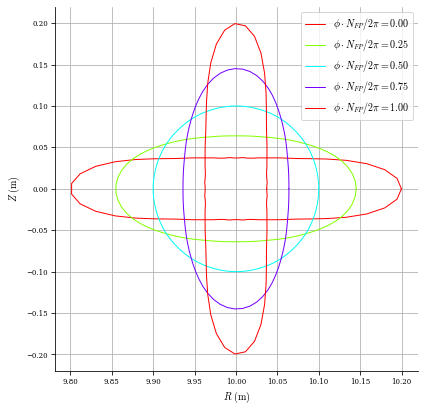

In [137]:
data = plot_boundary(eq,plot_axis=False,phi = np.linspace(0,2*np.pi,5),return_data = True)
plt.grid()

In [139]:
eq

Equilibrium at 0x33e5863c0 (L=10, M=15, N=5, NFP=1, sym=False, spectral_indexing=ansi)

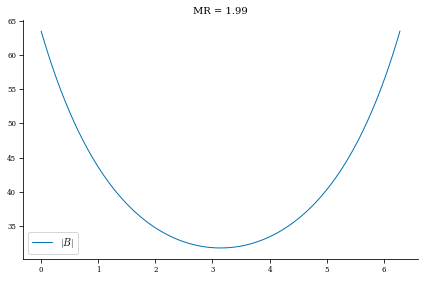

In [141]:
# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
Nz = 100
zeta_axis = np.linspace(0, 2 * np.pi, Nz)
rho_axis = np.ones_like(zeta_axis) * 0
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(["|B|", "Y"], grid=grid_axis)
B_axis = data_axis["|B|"]

plt.figure()
plt.plot(zeta_axis, B_axis, label=r"$|B|$")
plt.title("MR = {:.2f}".format(np.max(B_axis) / np.min(B_axis)))
plt.legend()

In [777]:
Nz = 200
Nt = 10
rho_surf = 1

# Flux surfaces on which to evaluate 
surfaces = np.array([rho_surf])
# Field lines on which to evaluate 
alpha = np.linspace(0, 2 * np.pi, Nt, endpoint=False)
# Number of point along a field line 
zeta = np.linspace(0, 2 * np.pi, Nz)

# we need to make a special grid in field aligned coordinates, which we do here
# coordinates="raz" tells desc that this grid is in rho,alpha,zeta coordinates.
grid = Grid.create_meshgrid([surfaces, alpha, zeta], coordinates="raz")

In [778]:
data = surf.compute(
    [
        "X",
        "Y",
        "Z",
    ],
    grid=grid,
)

/Users/djinpatch/CODE/DESC/desc/utils.py:572: UserWarning: Expected coordinates rtz got raz.
  warnings.warn(msg, err)


In [44]:
from mayavi import mlab

In [783]:
## plot B vectors 
# cylindrical grid
points = []
B = []
Ny = 40
Nt = 10
radial = np.linspace(.01,.01,1)
for r in radial:
    y = np.linspace(1,3,Ny)
    for yi in y:
        theta = np.linspace(0,2*np.pi,Nt)
        x = r*np.cos(theta)
        z = r*np.sin(theta)
        yt = np.ones_like(x)*yi
        points += [np.array([x,yt,z]).T]
        B += [coilset.compute_magnetic_field(np.array([x, yt, z]).T, basis="xyz")]


points = np.array(points)
B = np.array(B)


In [103]:
x = data["X"]
y = data["Y"]
z = data["Z"]
# b = data['p']
# bv = data['grad(p)']

fig = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0.0, 0.0, 0.0))

mlab.points3d(x, y, z, scale_factor=0.01, scale_mode="none")



coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

#mlab.quiver3d(points[:,:,0],points[:,:,1],points[:,:,2],B[:,:,0],B[:,:,1],B[:,:,2])

mlab.points3d(X,Y,Z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))



mlab.show()

In [143]:
surf.save('quad_surf.hdf5')

In [58]:

fig = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0.0, 0.0, 0.0))



coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x,y,z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

#mlab.quiver3d(points[:,:,0],points[:,:,1],points[:,:,2],B[:,:,0],B[:,:,1],B[:,:,2])

mlab.points3d(X,Y,Z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))



mlab.show()

In [62]:
path.shape

(39999, 500, 3)

In [120]:
fig = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0.0, 0.0, 0.0))



coil_data = coilset.compute(["X", "Y", "Z"])

for i in coil_data:
    x = i["X"]
    y = i["Y"]
    z = i["Z"]
   # mlab.plot3d(x,y,z, tube_radius = .01,opacity=.5, color = (.5,.5,.5))
    mlab.points3d(x+10,z,y,scale_factor = .01,opacity=.5, color = (.5,.5,.5))

#mlab.quiver3d(points[:,:,0],points[:,:,1],points[:,:,2],B[:,:,0],B[:,:,1],B[:,:,2])



mlab.points3d(X,Y,Z,scale_factor = .01,opacity=.5, color = (.5,.5,.5))



mlab.show()